# Flowers Dataset
http://www.robots.ox.ac.uk/~vgg/data/flowers/17/

In [226]:
import numpy as np 
import matplotlib.pyplot as plt
import keras
# from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, Deconvolution2D
import os, glob
import PIL
from PIL import Image
from sklearn.model_selection import train_test_split

In [227]:
im_size = 32

def load_flower_segmentation_data():
    X = []
    y = []
    for f_name in glob.glob("data/jpg/*.jpg"):
        try:
            class_index = (int(f_name.split('image_')[1][0:4])-1)/80
            class_index_one_hot = keras.utils.to_categorical(class_index, 17)[0]


            image = Image.open(f_name)
            image = image.resize((im_size, im_size))
            image = np.asarray(image).astype('float32')/255.

            segmentation_name = f_name.replace('/jpg/', '/trimaps/').replace('.jpg', '.png')
            segmentation = Image.open(segmentation_name)
            segmentation = segmentation.resize((im_size, im_size))
            segmentation = np.asarray(segmentation).astype('float32')
            segmentation_binary = np.zeros((im_size, im_size, 2))
            segmentation_binary[:,:,0] = (segmentation == 3.)
            segmentation_binary[:,:,1] = (segmentation == 1.)
            segmentation_binary_flat = segmentation_binary.reshape(im_size*im_size, 2)

            X.append(image)
            y.append(segmentation_binary_flat)
        except Exception as e:
            pass
    X, y = np.array(X), np.array(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test

In [228]:
X_train, X_test, y_train, y_test = load_flower_segmentation_data()

In [229]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)

('X_train shape:', (568, 32, 32, 3))
('X_test shape:', (280, 32, 32, 3))
('y_train shape:', (568, 1024, 2))


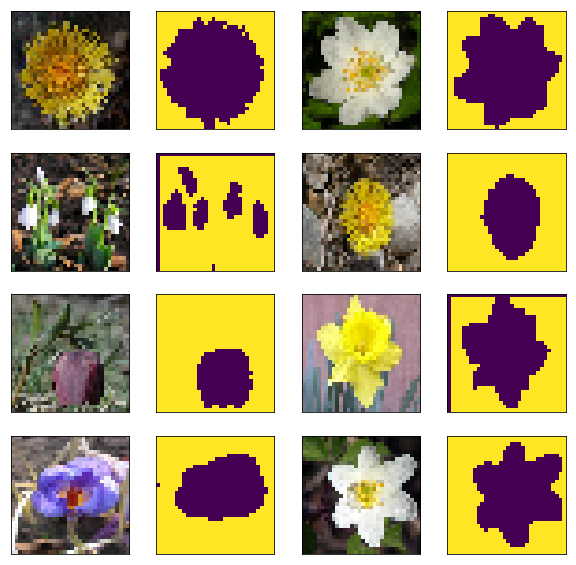

In [230]:
fig = plt.figure(figsize=(10,10))

for i in range(0, 16, 2):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(X_train[i,:].reshape(im_size, im_size, 3), interpolation='nearest')
    ax = fig.add_subplot(4, 4, i+2, xticks=[], yticks=[])
    ax.imshow(y_train[i,:].reshape(im_size, im_size, 2)[:,:,0], interpolation='nearest')

plt.show()

In [231]:
batch_size = 32
epochs = 100
num_classes = 17

model = Sequential()

# Encoder
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Decoder
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Deconvolution2D(128, 2, 2, subsample=(2, 2), bias=False))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Deconvolution2D(32, 2, 2, output_shape=(None, im_size, im_size, 1), subsample=(2, 2), bias=False))
model.add(Activation('relu'))
model.add(Conv2D(2, (3, 3), padding='same'))
_, curr_width, curr_height, curr_channels = model.layers[-1].output_shape
model.add(Reshape((curr_width * curr_height, curr_channels)))
model.add(Activation('softmax'))

opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(128, (2, 2), strides=(2, 2), use_bias=False)`
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(32, (2, 2), strides=(2, 2), use_bias=False)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_149 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
activation_170 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_171 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 16, 16, 64)        18496     
__________

In [202]:
#train the model
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=50,
          validation_data=(X_test, y_test),
          shuffle=True)

Train on 568 samples, validate on 280 samples
Epoch 1/50
568/568 [==============================] - 10s - loss: 0.5894 - acc: 0.6706 - val_loss: 0.5784 - val_acc: 0.7251
Epoch 2/50
568/568 [==============================] - 9s - loss: 0.5683 - acc: 0.7316 - val_loss: 0.5351 - val_acc: 0.7300
Epoch 3/50
568/568 [==============================] - 10s - loss: 0.4637 - acc: 0.7747 - val_loss: 0.3487 - val_acc: 0.8230
Epoch 4/50
568/568 [==============================] - 9s - loss: 0.3264 - acc: 0.8134 - val_loss: 0.2970 - val_acc: 0.8223
Epoch 5/50
568/568 [==============================] - 10s - loss: 0.3128 - acc: 0.8143 - val_loss: 0.2894 - val_acc: 0.8123
Epoch 6/50
568/568 [==============================] - 10s - loss: 0.2902 - acc: 0.8237 - val_loss: 0.2750 - val_acc: 0.8351
Epoch 7/50
568/568 [==============================] - 11s - loss: 0.2818 - acc: 0.8275 - val_loss: 0.2602 - val_acc: 0.8323
Epoch 8/50
568/568 [==============================] - 9s - loss: 0.2694 - acc: 0.8364 - 

In [8]:
# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

448/449 [============================>.] - ETA: 0s('Test loss:', 1.5955929235785469)
('Test accuracy:', 0.63251670378619151)


In [9]:
# Save model weights
save_dir = 'saved_models'
model_name = 'flowers_segmentation_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

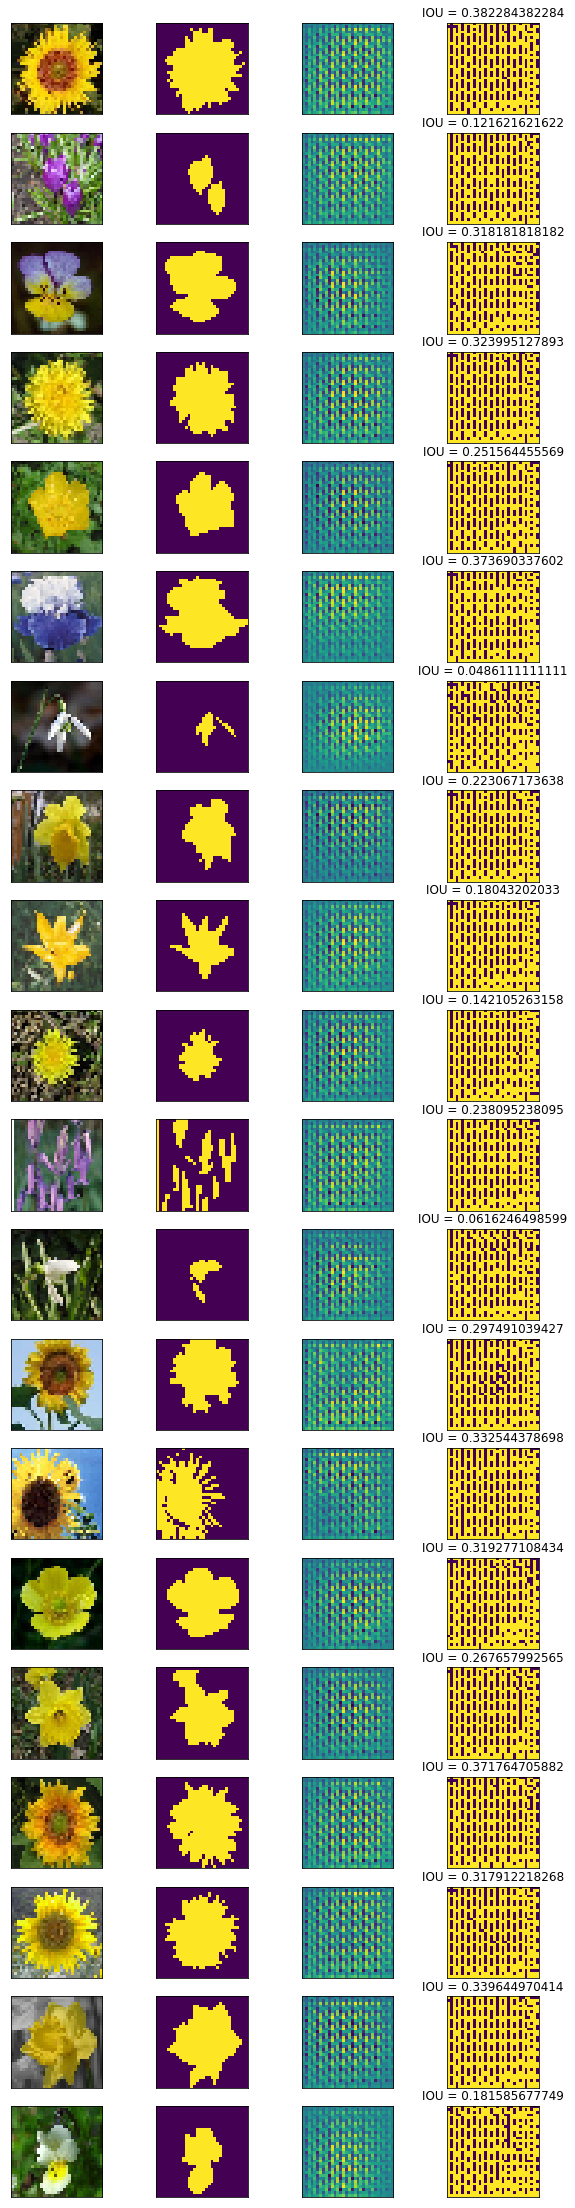

In [232]:
# plot predictions vs truth
num_samples = 20
fig = plt.figure(figsize=(10, 2*num_samples))

for i in range(0, 4*num_samples, 4):
    segment_pred = model.predict(np.array([X_test[i,...]]))
    ax = fig.add_subplot(num_samples, 4, i+1, xticks=[], yticks=[])
    segment_truth = y_test[i,:].reshape(im_size, im_size, 2)[:,:,1]
    ax.imshow(X_test[i,:].reshape(im_size, im_size, 3), interpolation='nearest')
    ax = fig.add_subplot(num_samples, 4, i+2, xticks=[], yticks=[])
    ax.imshow(segment_truth, interpolation='nearest')
    ax = fig.add_subplot(num_samples, 4, i+3, xticks=[], yticks=[])
    ax.imshow(segment_pred.reshape(im_size, im_size, 2)[:,:,1], interpolation='nearest')
    ax = fig.add_subplot(num_samples, 4, i+4, xticks=[], yticks=[])
    
    binary_pred = segment_pred.reshape(im_size, im_size, 2)[:,:,1] > 0.5
    ax.imshow(binary_pred, interpolation='nearest')

    binary_pred_flat = binary_pred.reshape(im_size* im_size)
    segment_truth_flat = segment_truth.reshape(im_size* im_size)
    
    intersection = np.sum((binary_pred_flat + segment_truth_flat == 2.0))
    union = np.sum(np.clip((binary_pred_flat + segment_truth_flat), 0.0, 1.0))

    iou = intersection/union
    ax.set_title('IOU = {}'.format(iou))
    
plt.show()